In [1]:
%load_ext autoreload
%autoreload 2
import plotly.io as pio
pio.renderers.default='notebook'

import os
import numpy as np

In [38]:
def projection(pt_infront, calib, fisheye):
    a, b = pt_infront[0,:]/pt_infront[2,:], pt_infront[1,:]/pt_infront[2,:]
    if fisheye:
        k1, k2, p1, p2,  k3 = -3.77171309e-01,  1.90805099e+00,  1.49424193e-03, -5.44006658e-03, -6.22743876e+00
        r = (a**2 + b**2)**0.5
        u = 1.84852409e+03*a + 7.96736294e+02
        v = 1.83675470e+03*b + 6.89480920e+02
        
        u = u*(1+k1*r**2+k2*r**4+k3*r**6)
        v = v*(1+k1*r**2+k2*r**4+k3*r**6)
        u = u + (2*p1*u*v + p2*(r**2 + 2*u**2))
        v = v + (p1*(r**2+2*v**2) + 2*p2*u*v)
    else:
        u = 1.84852409e+03*a + 7.96736294e+02
        v = 1.83675470e+03*b + 6.89480920e+02
    return u, v

In [39]:
import glob
root = '/home/xc429/Junan/calib_test/data2/cache'

In [40]:
import json
with open('calibration.json') as f:
    calib = json.load(f)
    
# Rot = calib['203_to_LCAM']['Rot_203']
# T = calib['203_to_LCAM']['T_203']
# Rot = np.asarray(Rot)
# T = np.asarray(T)
Rot = np.array([[ 0.7624643 , -0.64634549, -0.02976072],
       [-0.04196313, -0.00349823, -0.99911304],
       [ 0.6456681 ,  0.76303687, -0.02978996]])
T = np.array([[-0.07946306],
       [-0.08448351],
       [ 0.0470211 ]])

In [41]:
img_dir = os.path.join(root,'camera_front_left_60fov/*')
img_files = glob.glob(img_dir)
img_ts = [os.path.split(path)[1] for path in img_files]
img_ts = [int(t.split('.')[0]) for t in img_ts]
assert len(img_ts)==len(img_files)
print("how many img files: ", len(img_files))

lidar_dir = os.path.join(root,'lidar_203/data/*')
lidar_files = glob.glob(lidar_dir)
lidar_ts = [int(os.path.split(path)[1]) for path in lidar_files]
assert len(lidar_ts)==len(lidar_files)
print("how many lidar files: ", len(lidar_files))

how many img files:  55930
how many lidar files:  18479


In [46]:
def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float32)
    points = bin_pcd.reshape(-1,5)
#     print('diff', points[-1,4]-points[0,4])
    return points[:,:3],points[:,3],points[:,4]

def getLastUnixHour_array(time_list):
    array_cam = np.sort(np.asarray(time_list,dtype=np.float))
    last_unix_hour = int(array_cam[0]-(array_cam[0] % (1E6*3600)))
#     print('last hour',last_unix_hour)
    return last_unix_hour


idx = 16000#10755#15000#11500#11000#8000#12000 #16000
pts, intensity, times = load_pcl_from_bin5(lidar_files[idx])
os.path.split(lidar_files[idx])[1]
last_unix_hour = getLastUnixHour_array(lidar_ts)
times_for_each_point= times+last_unix_hour
np.mean(times_for_each_point)
print(last_unix_hour)
print(times_for_each_point[0])
lidar_files[idx]

1607108400000000
1607112277437440.0


/home/xc429/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



'/home/xc429/Junan/calib_test/data2/cache/lidar_203/data/1607112277437436'

In [43]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

im = cv2.imread(img_files[idx])
m,n = im.shape[0], im.shape[1]

pts_cam = np.dot(Rot,pts.T) + T.reshape(-1,1) 
pts_cam = pts_cam.T

idx_infront = pts_cam[:,2] >= 0
pts_infront = pts_cam[idx_infront,:]
times_infront = times_for_each_point[idx_infront]

u,v = projection(pts_infront.T, calib, fisheye=True)

flag_within_img = (u>0)*(u<n)*(v>0)*(v<m)
pts_infront = pts_infront[flag_within_img]
times_infront = times_infront[flag_within_img]
u = u[flag_within_img]
v= v[flag_within_img]
print(len(pts_infront))
time_lidar = np.mean(times_infront)
time_lidar

281


1607112277505884.0

'/home/xc429/Junan/calib_test/data2/cache/camera_front_left_60fov/1607112277504625.jpg'

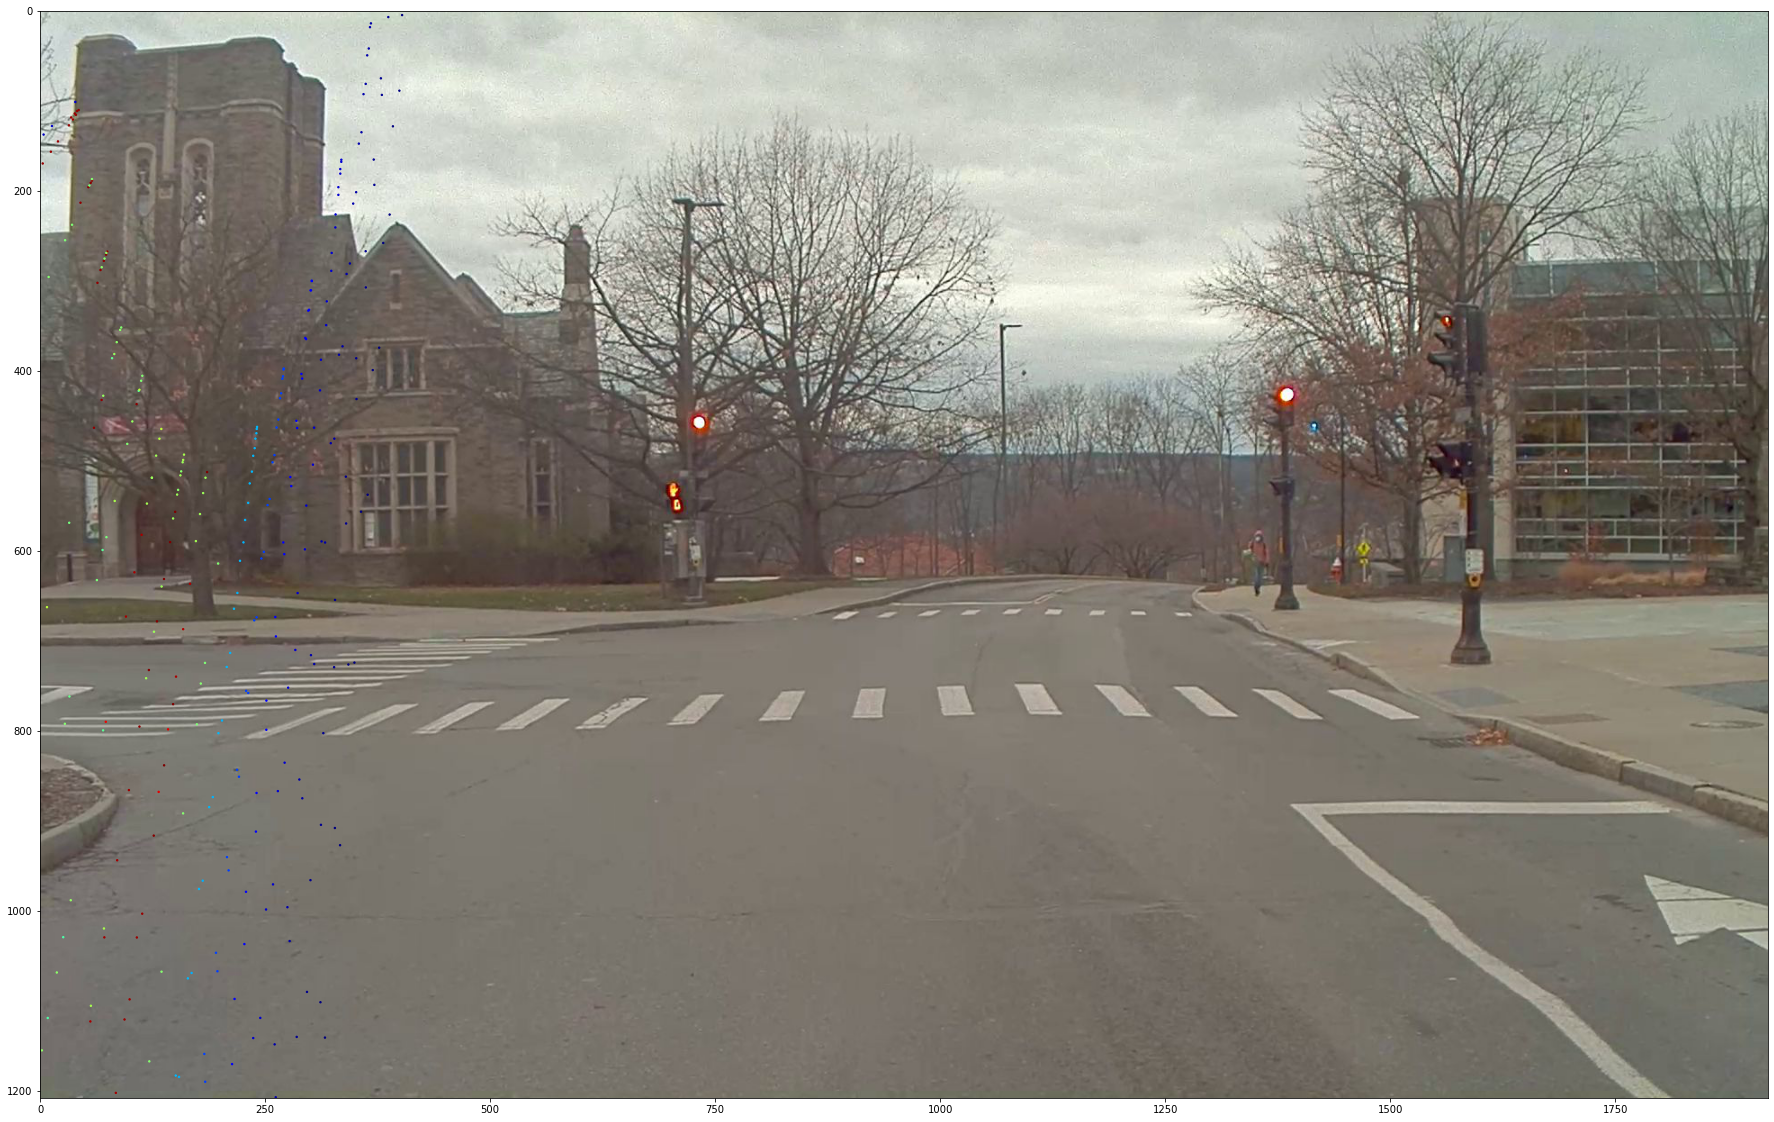

In [45]:
idx_match = np.argmin(abs(np.asarray(img_ts) - time_lidar))
img_file = os.path.split(img_files[0])[0] + '/' + str(img_ts[idx_match]) + '.jpg'
cmap = cm.get_cmap('jet')

img = plt.imread(img_file)
plt.figure(figsize = (200,20))
plt.imshow(img)
plt.scatter(u,v, s = 2, c=pts_infront[:,2],cmap = cmap)
img_file

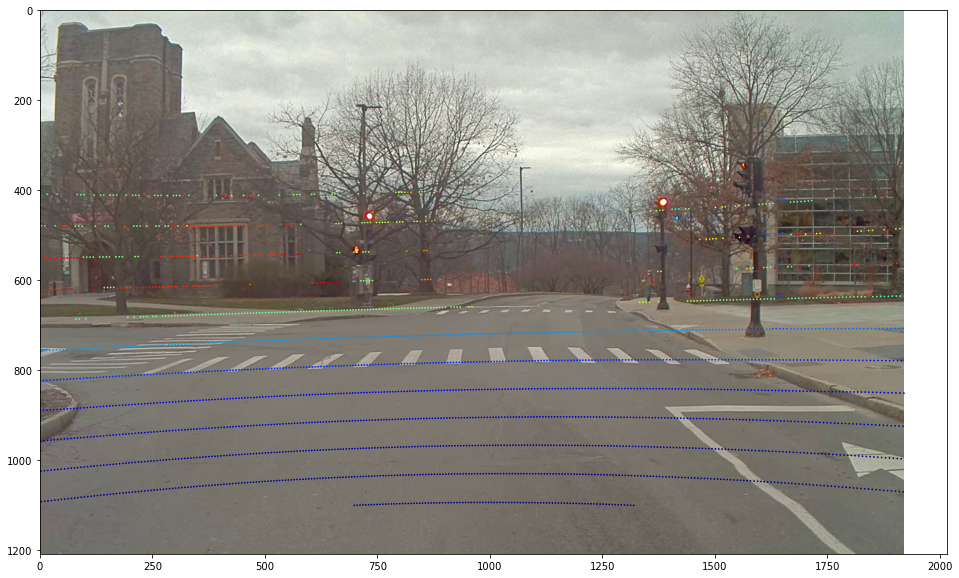

In [13]:
idx_match = np.argmin(abs(np.asarray(img_ts) - time_lidar))
img_file = os.path.split(img_files[0])[0] + '/' + str(img_ts[idx_match+1]) + '.jpg'
cmap = cm.get_cmap('jet')

img = plt.imread(img_file)
plt.figure(figsize = (100,10))
plt.imshow(img)
plt.scatter(u,v, s = 0.5, c=pts_infront[:,2],cmap = cmap)

In [101]:
img_ts[idx_match+1]

1607111470631649

In [102]:
img_ts[idx_match]

1607111470598309

In [103]:
lidar_ts[idx]

1607111470557388

In [48]:
n

1920